# Preprocesamiento de datos

In [274]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

In [275]:
df_train = pd.read_csv('data/train.csv')

### Un poco de preproceso

Antes de empezar a analizar los datos, vamos a realizar algunos procesos previos y obtener algunas variables que nos van a ser útiles más adelane:

- Lista de las columnas numéricas (dividida por tipos de acuerdo a lo que miden)
- Lista de las variables categóricas (dividida por tipos de acuerdo a lo que miden)
- Lista de variables ordinales (dividida por tipos de acuerdo a lo que miden)

También vamos a reemplazar algunos `NA` por un valor más significativo ya que muchos de estos se refieren en realidad a que no existe cierta condición y no a que haya un dato faltante

In [276]:
#1. Convertimos valores faltantes en "No" para expresar realmente lo que quieren decir
meaningfulNA = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
df_train[meaningfulNA] = df_train[meaningfulNA].fillna('No')

#2. Obtenemos una lista de las variables numéricas y contínuas, para esto hay que quitar las variables que son ordinales 
# y ya están codificadas como números. En el camino vamos a hacer una lista de las variables que tienen que ver condiciones de calidad 
# (ordinales) pero no codificadas como números y también una lista de variables categóricas

qualCon = ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 
           'PoolQC', 'BsmtQual', 'BsmtCond', 'OverallQual', 'OverallCond']
# Esta es una clasificación con código numérico pero que no representa una variable ordinal
compl = ['MSSubClass']
cat = df_train.select_dtypes(include=['object']).columns.tolist()
cat = set(cat).difference(qualCon + compl)
num = df_train.select_dtypes(exclude=['object']).columns
num = set(num).difference(qualCon + compl)

# Listas de variables por "cosa" que miden y tipo de dato

# Numéricas
total = ['LowQualFinSF'] # se refiere al total de la casa
floor = ['TotalBsmtSF', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF']
room = ['BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd']
rest = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath','HalfBath']
bsmt = ['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
area = ['GrLivArea', 'LotArea', 'LotFrontage']
garage = ['GarageArea', 'GarageCars', 'GarageYrBlt']
outRoom = ['Fireplaces', 'WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
# Fechas
season = ['YearRemodAdd', 'GarageYrBlt', 'YearBuilt']
season2 = ['MoSold', 'YrSold']
#Catgóricas
total2 = ['MSSubClass','MSZoning','BldgType','Foundation','HouseStyle']
material = ['RoofStyle', 'RoofMatl',  'MasVnrType', 'Electrical','Exterior1st', 'Exterior2nd']
bsmt2 = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
area2 = ['LotShape','LotConfig']
garage2 = ['GarageType', 'GarageFinish'] 
outRoom2 = ['Heating', 'CentralAir','Fence', 'MiscFeature']
town2 = ['Neighborhood','LandContour','LandSlope','Condition1', 'Condition2']
system2 = ['Street', 'Alley','PavedDrive',  'Utilities','Functional', 'SaleType', 'SaleCondition']
#Ordinales
total3 = ['OverallQual', 'OverallCond', 'MSSubClass']
material3 = [ 'ExterQual', 'ExterCond']
bsmt3 = ['BsmtQual', 'BsmtCond']
room3 = ['KitchenQual']
garage3 = ['GarageQual', 'GarageCond']
outRoom3 = ['FireplaceQu','HeatingQC', 'PoolQC']
ordVar = total3+material3+bsmt3 + room3 + garage3 + outRoom3


Estas listas nos pueden ayudar a diferentes etapas del proceso, por ejemplo para tratar de forma diferente las variables de acuerdo a su tipo y propósito.

### SalePrice

Lo primero es ver que tal se porta la variable objetivo. Ver su distribución y examinar qué tanto se parece a una normal ¿por qué es importante?

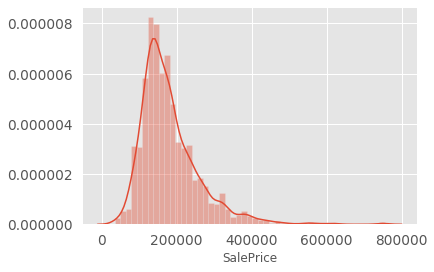

In [277]:
sns.distplot(df_train['SalePrice'])

Pues no parece una distribución normal. Lo podemos comprobar visualmente usando un qqplot 

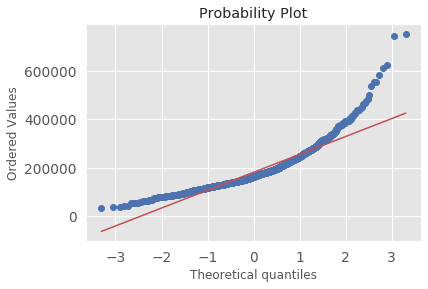

In [278]:
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

Aquí es mucho más claro que la distribución no es normal. Está sesgada a la derecha. En estos casos, hay una solución muy fácil, transformar usando el logaritmo.

¿Por qué funciona eso?

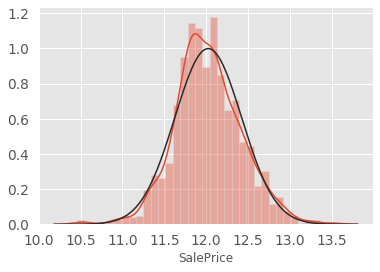

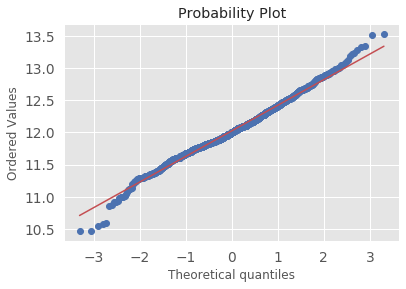

In [279]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])
sns.distplot(df_train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

Mucho mejor!!!!

Ahora, esto puede pasar con todas las variables numéricas, entonces vamos a observar las distribuciones de aquellas variables que estén demasiado sesgadas o tengan demasiada kurtosis.

Es importante distinguir los casos en los que las distribuciones incluyen o no ceros!!!

In [280]:
overSkew = df_train.loc[:,num].columns[df_train.loc[:,num].skew() > 2.5].values
overKurt = df_train.loc[:,num].columns[df_train.loc[:,num].kurt() > 2.5].values
lowKurt = df_train.loc[:,num].columns[df_train.loc[:,num].kurt() < -2.5].values
if not overSkew.size: print('overSkew: ' ,overSkew) 
else:print('Tenemos variables sesgadas')
if not overKurt.size: print('overKurt: ' ,overKurt) 
else: print('Tenemos variables con alta kurtosis')
if not lowKurt.size: print('lowKurt is None + No uniform distribution in Data Sets')
else: print('Tenemos variables con baja kurtosis')

overDist = set(overSkew).union(set(overKurt)).union(set(lowKurt))
modNum = set(num) - overDist
zeroNum = df_train.loc[:, overDist].columns[(df_train.loc[:, overDist] == 0).sum() > 100]
overDistN0 = overDist - set(zeroNum)
overDist0 = set(zeroNum)
#print(list(zeroNum))
print('Variables distorsionadas (sin ceros) ', overDistN0)
print('Variables distorsionadas (con muchos ceros) ',overDist0)

Tenemos variables sesgadas
Tenemos variables con alta kurtosis
lowKurt is None + No uniform distribution in Data Sets
Variables distorsionadas (sin ceros)  {'KitchenAbvGr', 'GrLivArea', 'LotArea', 'LotFrontage', '1stFlrSF', 'TotalBsmtSF'}
Variables distorsionadas (con muchos ceros)  {'WoodDeckSF', 'BsmtFinSF2', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF1', 'OpenPorchSF', 'LowQualFinSF', 'ScreenPorch', 'EnclosedPorch', 'PoolArea', '3SsnPorch', 'MasVnrArea'}


Grafiquemos las distribuciones y veamos los valores de su sesgo y kurtosis

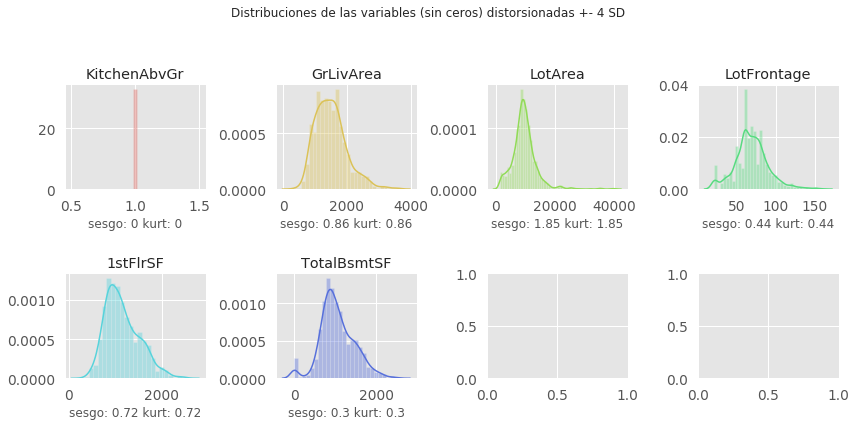

In [281]:
tmp_train = df_train.loc[:,overDistN0].dropna()
def reject_outliers(data, m=4):
    # con esta función quitamos outliers (por default lejanos 4 veces de la std) para que no molesten en las gráficas
    return data[abs(data - np.mean(data)) < m * np.std(data)]
f, axes = plt.subplots(2, 4, figsize = (12, 6), sharey = False)
colors = sns.color_palette("hls", 8)
for ix, var in enumerate(tmp_train.columns):
    row, col = divmod(ix, 4)
    tmpVar = reject_outliers(tmp_train[var])
    var_label = 'sesgo: ' + str(round(tmpVar.skew(),2)) + ' kurt: ' + str(round(tmpVar.skew(),2))
    axes[row,col] = sns.distplot(tmpVar,kde = True, ax = axes[row, col], color =colors[ix])
    axes[row, col].set_title(var)
    axes[row, col].set_xlabel(var_label)
plt.suptitle('Distribuciones de las variables (sin ceros) distorsionadas +- 4 SD', fontsize = 12)
plt.tight_layout()
plt.subplots_adjust(wspace = 0.5, hspace = 0.8, top = 0.8)
plt.show()
#print(df_train.loc[:,overDistN0].apply(reject_outliers).dropna().apply(lambda x: pd.Series({'kurt': kurtosis(x), 'skew' : skew(x)})).T)
del tmp_train


En realidad, la única que realmente presaenta problemas serios es `LotArea`. Vemos qué transformación funciona mejor a corrijamos sus valores

In [282]:
# Tres transformaciones diferentes para corregir las distorsiones
logLot = np.log1p(df_train['LotArea']).kurt()
rootLot = np.sqrt(df_train['LotArea']).kurt()
cubicLot = np.power(df_train['LotArea'],2).kurt()

# Probamos cual corrige mejor
minVal = min([logLot, rootLot, cubicLot])
if logLot == minVal:
    best = 'log'
    df_train['LotArea'] = np.log1p(df_train['LotArea'])
elif rootLot == minVal:
    best = 'root'
    df_train['LotArea'] = np.sqrt(df_train['LotArea'])
elif cubicLot == minVal:
    best = 'cubic'
    df_train['LotArea'] = np.power(df_train['LotArea'],2)
print('La mejor transformación es ' + best)

La mejor transformación es log


Aplicamos el mismo proceso para las variables con muchos ceros (¿qué es lo diferente?)

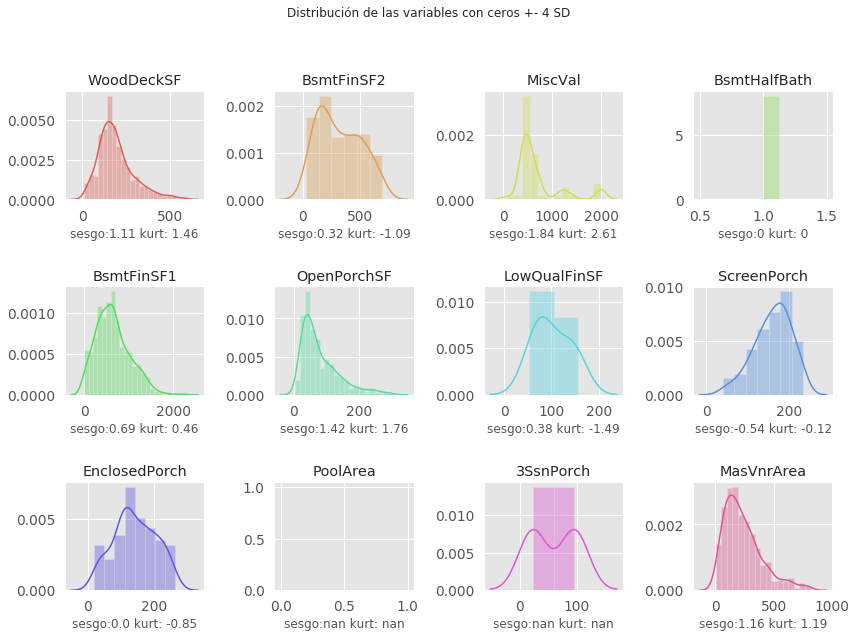

In [283]:
tmp_train = df_train.loc[:,overDist0].dropna()
def reject_outliers2(data, m=4):
    data = data[abs(data - np.mean(data)) < m * np.std(data)]
    return data.loc[data != 0]
f, axes = plt.subplots(3, 4, figsize = (12, 9), sharey = False)
colors = sns.color_palette("hls", 12)
dataF = dict()
for ix, var in enumerate(tmp_train.columns):
    row, col = divmod(ix, 4)
    tmpVar = reject_outliers2(tmp_train[var])
    var_label = 'sesgo:'+ str(round(tmpVar.skew(),2)) + ' kurt: ' + str(round(tmpVar.kurt(),2))
    sns.distplot(tmpVar,kde = True, ax = axes[row, col], color =colors[ix])
    axes[row,col].set_title(var)
    axes[row,col].set_xlabel(var_label)
plt.tight_layout()
plt.subplots_adjust(wspace = 0.5, hspace = 0.8, top = 0.85)
plt.suptitle('Distribución de las variables con ceros +- 4 SD', fontsize = 12)
plt.show()

del tmp_train

Aquí no se ven problemas graves entonces podemos seguir adelante

### Explorando las relaciones entre variables

Primero vamos a ver cómo se relacionan las variables numéricas con nuestro objetivo. Primero vamos a explorar la matriz de correlaciones para las variables numéricas sin ceros



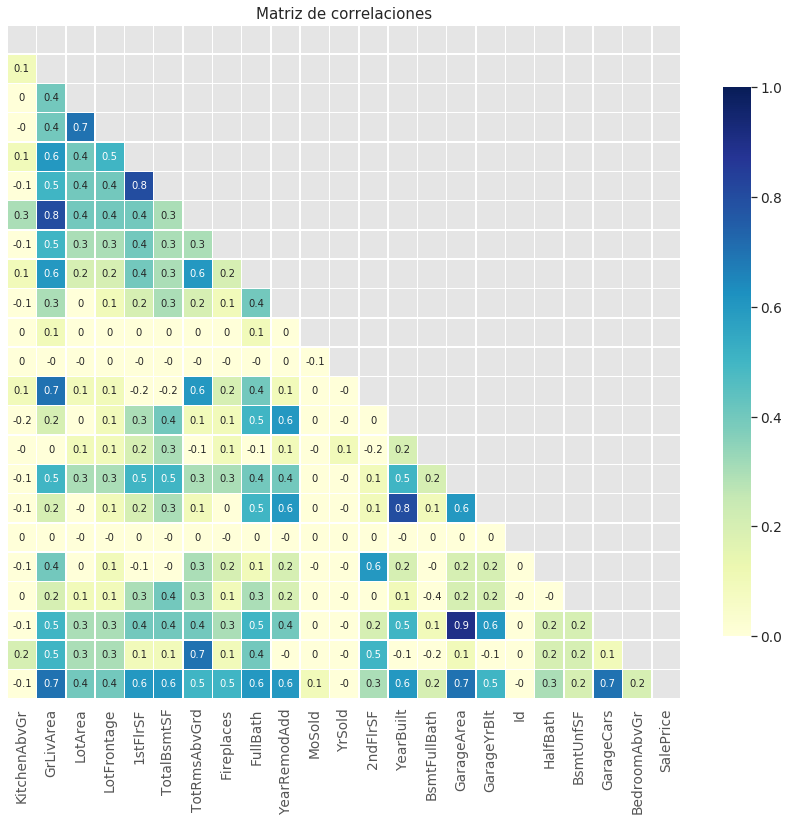

In [284]:
num_none_zero = list(overDistN0) + list(modNum)
for ix, x in enumerate(num_none_zero):
    if x == 'SalePrice':
        salePos = ix
        break
num_none_zero[salePos], num_none_zero[len(num_none_zero) - 1] = num_none_zero[len(num_none_zero) - 1], num_none_zero[salePos]

numCorr = df_train.loc[:,num_none_zero].corr().round(1)

f, ax = plt.subplots(1,1, figsize = (12, 12))
mask = np.zeros_like(numCorr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(numCorr, annot = True, mask=mask, vmin =0, square=True, linewidths = .5, cmap="YlGnBu", ax = ax,
               cbar_kws = {'shrink' : 0.7})
    ax.set_yticks([])
    bottom, top = ax.get_ylim() ## Estas dos líneas son para corregir un bug en seaborn
    ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Matriz de correlaciones", fontsize = 15)
plt.tight_layout()
plt.show()

Las variables de Kitchen, Bedroom y Bath (excepto FullBath) muestran muy poca relación con nuestro objetivo, entonces las vamos a quitar del dataframe

In [285]:
dropNoCorr = ['BsmtFullBath', 'BsmtHalfBath','HalfBath', 'KitchenAbvGr','BsmtFullBath', 'BsmtHalfBath', 'FullBath','HalfBath', 'GarageYrBlt']
df_train.drop(dropNocorr,axis=1, inplace=True)

NameError: name 'dropNocorr' is not defined

### Valores faltantes

Tenemos valores faltantes en varias columnas, algo tenemos que hacer con ellos. El primer paso desde luego es ver en qué columnas y qué proporción.

In [ ]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

Aquí tenemos tres opciones para remediar los valores perdidos:

- Eliminar los registros
- Eliminar las columnas
- Imputar las variables

Para el caso del valor faltante en `Electrical` lo mejor es eliminar el registro, es sólo uno y por lo tanto no vamos a perder mucha información, para los casos de `MasVnrType` y  `MasVnrArea` de alguna forma estamos en el límite, entonces vale la pena investigar un poco más, por ejemplo, en ambos casos hay 8 registros faltantes ¿son los mismos?

In [ ]:
df_train[df_train['MasVnrType'].isnull()]['MasVnrArea']

Ok, entonces los registros que tienen faltante en uno, tienen también faltante en el otro. `MasVnrType` es categórica, pero `MasVnrArea` es numérica, investiguemos entonces su correlación con el objetivo y las demás variables:

In [ ]:
df_train.corr()['MasVnrArea']

Pues tiene una correlación decente con el objetivo ($0.43$) y no pareces ser demasiado redundante con ninguna otra variable, entonces creo que lo más conveniente es imputarla. Vamos a suponer que los valores faltantes suceden complétamente al azar, es decir, que no depende de otras variables, en este caso, podemos imputar con una regresión basada en las demás variables

In [286]:
from sklearn import linear_model
# Seleccioné tres variables para la regresión de forma un poco arbitraria, basado en las correlaciones
dfImpute = df_train.loc[:, ['1stFlrSF', 'GrLivArea', 'GarageArea', 'MasVnrArea']].copy()
testIx = dfImpute.loc[:,'MasVnrArea'].isnull()
# train y test para la imputación
dfTrain = dfImpute.loc[~testIx, :]
dfTest = dfImpute.loc[testIx, :]
# modelo de regresión
lr = linear_model.LinearRegression()
lr.fit(dfTrain.loc[:, ['1stFlrSF', 'GrLivArea', 'GarageArea']], dfTrain.loc[:, 'MasVnrArea'])
lrImpute = lr.predict(dfTest.loc[:, ['1stFlrSF', 'GrLivArea', 'GarageArea']])
# Asigno los valores calculados
df_train.loc[testIx,'MasVnrArea'] = lrImpute

# vuelvo a ver los fltantes para ver que todo vaya bien
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrType,8,0.005479
Electrical,1,0.000685
SalePrice,0,0.000000


Bien, ya corregimos `MasVnrArea`, vamos a proceder exáctamente de la misma forma para `LotFrontage`

In [287]:
# Seleccioné otras tres variables de la misma forma que en la anterior
dfImpute = df_train.loc[:, ['1stFlrSF', 'LotArea', 'GarageArea','LotFrontage']].copy()
testIx = dfImpute.loc[:,'LotFrontage'].isnull()
# train y test para la imputación
dfTrain = dfImpute.loc[~testIx, :]
dfTest = dfImpute.loc[testIx, :]
# modelo de regresión
lr = linear_model.LinearRegression()
lr.fit(dfTrain.loc[:, ['1stFlrSF', 'LotArea', 'GarageArea']], dfTrain.loc[:, 'LotFrontage'])
lrImpute = lr.predict(dfTest.loc[:, ['1stFlrSF', 'LotArea', 'GarageArea']])
# Asigno los valores calculados
df_train.loc[testIx,'LotFrontage'] = lrImpute

# vuelvo a ver los fltantes para ver que todo vaya bien
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
GarageYrBlt,81,0.055479
MasVnrType,8,0.005479
Electrical,1,0.000685
SalePrice,0,0.000000
ExterCond,0,0.000000


Para el caso de `Electrical`, como sólo tenemos un registro faltante, lo mejor es eliminar el renglón 

In [288]:
df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index, inplace=True)

Ya sólo nos queda el caso de `MasVnrType` que es más complicado porque es categórica. Vamos a ver qué tanta influencia tiene sobre el objetivo. 

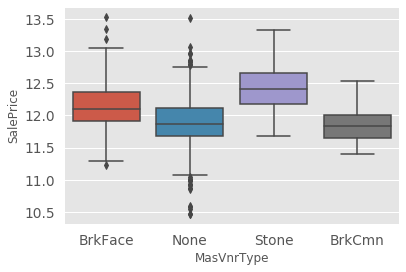

In [289]:
sns.boxplot(x = 'MasVnrType', y = 'SalePrice', data = df_train)

La verdad es que hay muy poca variación del objetivo, entonces podemos eliminar la variable sin ningun problema.

In [290]:
df_train.drop(['MasVnrType'], axis=1, inplace=True)

Entonces, ahora sí ya no tenemos datos faltantes por ningún lado ¿verdad?

In [291]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
GarageYrBlt,81,0.055517
Heating,0,0.000000
YearRemodAdd,0,0.000000
RoofStyle,0,0.000000
RoofMatl,0,0.000000


### Outliers

Ahora ya tenemos limpio nuestro dataset, pero todavía podemos tener problemas con los outliers. Como estamos haciendo una regresión, los valores extremos pueden ser problemáticos porque _jalan_ los promedios, entonces necesitamos identificarlos y eliminarlos.

En principio podemos pensar que hay dos tipos diferentes de outliers: univariados y multivariados, los outliers univariados son valores que se alejan mucho de _su_ propia distribución, mientras que los multivariados se alejan de las distribuciones _conjuntas_.

El proceso que vamos a seguir para identificar outliers en las variables continuas es asi:

- Primero vamos a encontrar _candidatos_ a outliers basados en las distribuciones univariadas
- Vamos a ver las distribuciones conjuntas entre las variables y el objetivo
- A partir de eso encontraremos observaciones candidatas a ser eliminadas de la muestra

Empecemos con los outliers univariados, para eso vamos a identificar las observaciones que se separen mas de 4 desviaciones estándar en sus distribuciones. Eso lo vamos a hacer con la función `checkOutlier` que definimos a continuación, también vamos a definir una función auxiliar `outlierCounter` para llevar registro de los candidatos. En esta función vamos a registrar el índice y las variables en las que ese índice aparece como outlier

In [292]:
def checkOutlier(df, m = 4):
    """rrecibe un dataframe con sólo las variables de intervalo"""
    uniOutlier = dict().fromkeys(df.columns, None)
    outSample = abs(df - df.mean()) > 4 * df.std()
    outSum = (abs(df - df.mean()) > 4 * df.std()).sum()
    for key in uniOutlier.keys():
        uniOutlier[key] = set(outSample.index[outSample.loc[:, key]])
    outportion = outSum / df.shape[0]
    print("No contienen ouliers: " ,outSum.index[outportion == 0].tolist())
    outportion = outportion[outportion != 0].sort_values()
    outlierLst = outportion.index.tolist()
    return uniOutlier, outlierLst

from collections import Counter
from collections import defaultdict
def outlierCounter(outlierDict, exceptionLst = ['SalePrice']):
    inter = Counter()
    name = defaultdict(list)
    coreKey = set(outlierDict.keys()).difference(exceptionLst)
    for key in coreKey:
        value = outlierDict[key]
        for val in value:
            inter[val] += 1
            name[val].append(key)
    res = pd.DataFrame([inter, name], index = ['count', 'variable']).T
    res = res.sort_values('count', ascending = False)
    return res

In [293]:
# corremos la función para marcar candidatos
uniOutlier, outlierList = checkOutlier(df_train.loc[:, num_none_zero])

No contienen ouliers:  ['Fireplaces', 'FullBath', 'YearRemodAdd', 'MoSold', 'YrSold', '2ndFlrSF', 'YearBuilt', 'GarageYrBlt', 'Id', 'HalfBath', 'GarageCars', 'SalePrice']


In [294]:
outliersUnivariados = outlierCounter(uniOutlier, ['KitchenAbvGr','SalePrice'])
outliersUnivariados

,count,variable
1298,5,"[GrLivArea, LotFrontage, 1stFlrSF, TotalBsmtSF..."
523,3,"[GrLivArea, 1stFlrSF, TotalBsmtSF]"
496,2,"[1stFlrSF, TotalBsmtSF]"
635,2,"[TotRmsAbvGrd, BedroomAbvGr]"
335,1,[LotArea]
706,1,[LotArea]
249,1,[LotArea]
1190,1,[GarageArea]
581,1,[GarageArea]
440,1,[TotalBsmtSF]


Ahora vamos a ver los outliers bivariados analizando la distribución conjunta de cada variable contra el objetivo. Para esto simplemente vamos a asignar valores dependiendo del orden. Aquí vamos a marcar como otliers a los que salgan del rango de 4 veces la desviación estándar al 0.9994% de confianza. Entonces, vamos a hacer una función que los identifiqe y al mismo tiempo grafique las distribuciones bivariadas contra la normal (bivariada) que vamos a usar para seleccionar

In [295]:
from scipy.stats import multivariate_normal
def bivarCI(dfNum, y = 'SalePrice', outer = 10, z_score = 0.00006, cols = 2):
    """Toma el dataframe con variables de intervalos y las grafica contra el objetivo.
       Regresa la lista de candidatos
    """
    colNum = dfNum.shape[1]
    row, col = divmod(colNum-1, cols)
    if row == 1 and col == 0: row += 1
    if col != 0: row += 1
    
    
    z_under = z_score * 0.98
    z_upper = z_score * 1.02
    #print(dfNum.columns)
    biOutlier = dict().fromkeys(dfNum.columns, None)
    f, axes = plt.subplots(row, cols, figsize = (4*cols, 4*row))
    f.suptitle('Bivaraite CI', fontsize = 12)
    for ix, var1 in enumerate(dfNum.columns):
        if var1 == y: 
            pass
        else:
            r,c = divmod(ix-1, cols)
            dfPart = dfNum[[var1,y]]
            #dfPart = dfNum.loc[:,[var1,y]]
            dfPart = dfPart[~dfPart.isnull()].copy()
            mask = dfPart.loc[:, var1] != 0
            dfPart = dfPart.loc[mask != 0,:]
            dfPart = (dfPart - dfPart.mean()) / dfPart.std()
            F, X, Y, posProb = bivarConverter(dfPart, outer, z_under, z_upper, N = 700)
            axes[r,c].scatter(dfPart.loc[:, var1], dfPart.loc[:, y], alpha = 1)
            axes[r,c].set_title('Bivaraite CI ' + var1)
            axes[r,c].contourf(X, Y, posProb, alpha=0.5)
            dfPartProb = F.pdf(dfPart.values)
            outIndex = dfPart.index[dfPartProb < z_score]
            biOutlier[var1] = set(outIndex.tolist())
    f.tight_layout(rect = [0, 0.03, 1, 0.95])
    plt.show()
    
    return biOutlier

def bivarConverter(df, outer, z_under, z_upper, N = 500):
    """Genera la gráfica (en realidad la proyección) de la normal bivariada"""
    x_init, y_init = df.min() - outer
    x_end, y_end = df.max() + outer
    X = np.linspace(x_init, x_end, N)
    Y = np.linspace(y_init, y_end, N)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:,:,0] = X
    pos[:,:,1] = Y
    F = multivariate_normal(mean=df.mean().values, cov=df.corr().values)
    posProb = F.pdf(pos)
    posProb[(z_under < posProb) & (posProb < z_upper)] = 1
    posProb[(z_under > posProb) | (posProb < z_upper)] = 0
    
    
    return F , X, Y, posProb

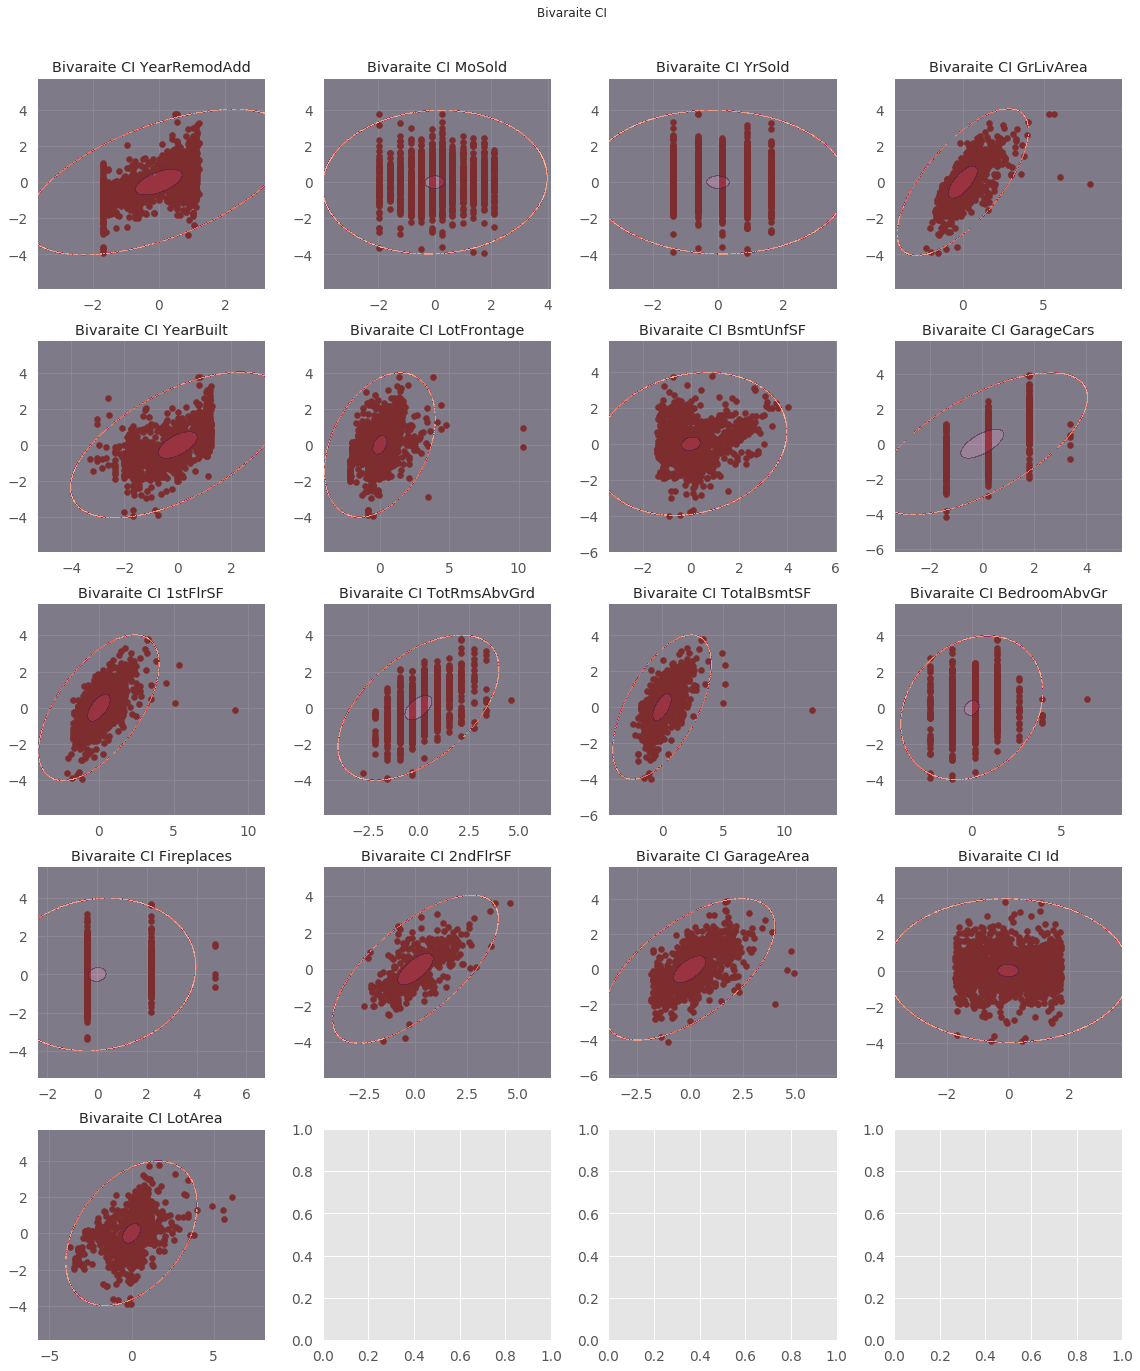

In [296]:
variables = set(num_none_zero).difference(dropNoCorr) # las que quedan vivas
biOutlier = bivarCI(df_train.loc[:,variables], outer = 2, z_score = 0.00006,  cols = 4)

Fireplaces, YrSold e Id (perdón, aquí no debería venir esa variable ¿verdad?) no corresponden a distribuciones normales bivariadas, entonces etiquetemos los outliers sin esas

In [297]:
outliersBivariados = outlierCounter(biOutlier, ['YrSold', 'SalePrice', 'Id'])
outliersBivariados

,count,variable
916,8,"[MoSold, YearBuilt, BsmtUnfSF, GarageCars, Bed..."
1298,8,"[GrLivArea, LotFrontage, 1stFlrSF, TotalBsmtSF..."
1182,7,"[YearRemodAdd, GrLivArea, YearBuilt, BsmtUnfSF..."
495,7,"[MoSold, GrLivArea, BsmtUnfSF, LotFrontage, 1s..."
691,6,"[YearRemodAdd, MoSold, GrLivArea, YearBuilt, F..."
30,5,"[GrLivArea, GarageCars, TotRmsAbvGrd, 2ndFlrSF..."
304,3,"[GrLivArea, YearBuilt, 2ndFlrSF]"
635,3,"[GrLivArea, BedroomAbvGr, TotRmsAbvGrd]"
523,3,"[GrLivArea, 1stFlrSF, TotalBsmtSF]"
968,3,"[GrLivArea, TotRmsAbvGrd, 2ndFlrSF]"


Intersectemos ahora las dos listas para definir mejor los candidatos 

In [298]:
def mergeTwoOut(uni, bi, cutoff = 1):
    """Regresa un dataframe con las observaciones que tienen outliers para los dos casos.
    """
    uni = uni.loc[uni.loc[:,'count'] != cutoff,:].copy()
    bi = bi.loc[bi.loc[:,'count'] != cutoff,:].copy()
    interIx = set(uni.index).intersection(bi.index)
    totCnt = uni.loc[interIx,'count'] + bi.loc[interIx,'count']
    totVar = (uni.loc[interIx,'variable'] + bi.loc[interIx, 'variable']).map(set)
    res = pd.concat([totCnt, totVar], axis = 1).sort_values('count', ascending = False)
    return res

interOut = mergeTwoOut(outliersUnivariados, outliersBivariados)
print(interOut)


     count                                           variable
1298    13  {Fireplaces, GrLivArea, GarageArea, LotArea, L...
523      6                 {1stFlrSF, GrLivArea, TotalBsmtSF}
635      5            {GrLivArea, BedroomAbvGr, TotRmsAbvGrd}
496      4                            {1stFlrSF, TotalBsmtSF}


Ahora veamos esos puntos en sus distribuciones

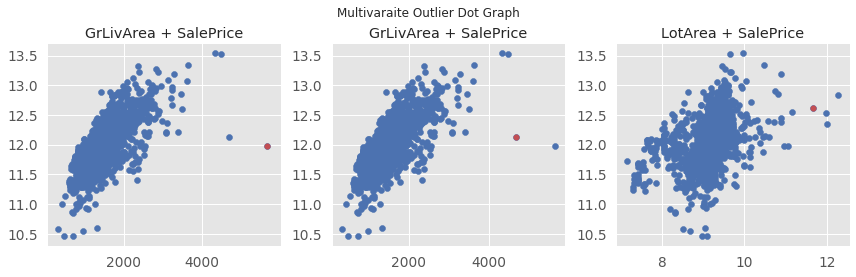

In [299]:
f, axes = plt.subplots(1,3, figsize = (12, 4))
f.suptitle('Multivaraite Outlier Dot Graph')
axes[0].scatter(df_train.loc[:,'GrLivArea'], df_train.loc[:, 'SalePrice'], c = 'b')
axes[0].scatter(df_train.ix[1298,'GrLivArea'], df_train.ix[1298, 'SalePrice'], c = 'r', s = 30)
axes[0].set_title('GrLivArea + SalePrice')
axes[1].scatter(df_train.loc[:,'GrLivArea'], df_train.loc[:, 'SalePrice'], c = 'b')
axes[1].scatter(df_train.ix[523,'GrLivArea'], df_train.ix[523, 'SalePrice'], c = 'r', s = 30)
axes[1].set_title('GrLivArea + SalePrice')
axes[2].scatter(df_train.loc[:,'LotArea'], df_train.loc[:, 'SalePrice'], c = 'b')
axes[2].scatter(df_train.ix[706,'LotArea'], df_train.ix[706, 'SalePrice'], c = 'r', s = 30)
axes[2].set_title('LotArea + SalePrice')
f.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

Pues definitivamente parecen outliers, entonces habrá que eliminarlos

In [300]:
df_train = df_train.drop(interOut.index)

 ### Codificación de variables

Primero vamos a codificar las variables que son ordinales. 

In [301]:
ordinales = ['ExterQual', 'KitchenQual']
#df_ordinales = df_train.loc[:, ordinales].copy()
df_train.loc[:,'ExterQual'] = df_train.loc[:,'ExterQual'].map({'Fa':1, 'TA':2, 'Gd' : 3, 'Ex': 4})
df_train.loc[:,'KitchenQual'] = df_train.loc[:,'KitchenQual'].map({'Fa':1, 'TA':2, 'Gd' : 3, 'Ex': 4})
df_train.loc[:,'ExterQual'].head()

0    3
1    2
2    3
3    2
4    3
Name: ExterQual, dtype: int64

Ahora vamos a aplicar _One Hot Encoding_ a las variables categóricas

In [303]:
categoricas = ['MSZoning','BsmtExposure', 'GarageFinish', 'GarageType', 'LotShape','LotConfig', 'CentralAir', 'Neighborhood']
df_cat = pd.get_dummies(df_train.loc[:, categoricas], prefix = categoricas)


In [265]:
df_cat

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,GarageFinish_Fin,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1456,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1457,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1458,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Ahora ya nada más nos falta juntar los dataframes, el original (ya procesado) y el dataframe con las categóricas ya codificadas. Por supuesto, también hay que quitar las categóricas originales

In [270]:
categoricas = ['MSZoning','BsmtExposure', 'GarageFinish', 'GarageType', 'LotShape','LotConfig', 'CentralAir', 'Neighborhood']
df_train[categoricas]

,MSZoning,BsmtExposure,GarageFinish,GarageType,LotShape,LotConfig,CentralAir,Neighborhood
0,RL,No,RFn,Attchd,Reg,Inside,Y,CollgCr
1,RL,Gd,RFn,Attchd,Reg,FR2,Y,Veenker
2,RL,Mn,RFn,Attchd,IR1,Inside,Y,CollgCr
3,RL,No,Unf,Detchd,IR1,Corner,Y,Crawfor
4,RL,Av,RFn,Attchd,IR1,FR2,Y,NoRidge
...,...,...,...,...,...,...,...,...
1455,RL,No,RFn,Attchd,Reg,Inside,Y,Gilbert
1456,RL,No,Unf,Attchd,Reg,Inside,Y,NWAmes
1457,RL,No,RFn,Attchd,Reg,Inside,Y,Crawfor
1458,RL,Mn,Unf,Attchd,Reg,Inside,Y,NAmes


In [305]:
#df_train = pd.concat([df_train, df_cat], axis=1)
#df_train.drop(categoricas, inplace=True)
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities',
       ...
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber',
       'Neighborhood_Veenker'],
      dtype='object', length=136)